This notebook demonstrates the testing for the constrained shortest path problem applied on the generated graphs from graph module.

In [1]:
# imports 
from pathlib import Path
import sys
# add <project>/src to sys.path
sys.path.insert(0, str(Path.cwd().resolve().parents[1]))

from motion_planning.utils.paths import GRAPH_DIR
from motion_planning.graph_construction.graph_assets import GRAPH_FILE_HANDLER
from motion_planning.graph_construction.route_loading import *



First, load the graphs

In [2]:

# load the graph
graphs_dict = {}
for map_id_key, scenario_key in routes_config.keys():
    try:
        graph_handler = GRAPH_FILE_HANDLER()
        graph_name = f"{map_id_key}_{scenario_key}"
        graph = graph_handler.load_graph(load_dir=GRAPH_DIR, scenario=graph_name)
        
        graphs_dict[graph_name] = graph
        print(f"Successfully loaded graph: {graph_name}")
    except Exception as e:
        print(f"Failed to load graph: {graph_name}. Error: {e}")



Successfully loaded graph: Town01_T-Intersection
Successfully loaded graph: Town03_Roundabout
Successfully loaded graph: Town05_Highway1
Successfully loaded graph: Town05_Highway2
Successfully loaded graph: Town05_Highway3
Successfully loaded graph: Town05_Multiple Intersections


2- generate risks for 

In [3]:
from motion_planning.risk_assessment.generate_risks_randomly import*
risk_level = RiskLevel.LOW
risk_matrix = generate_random_risks(graphs_dict["Town01_T-Intersection"],risk_level, 5.0)
# for u,v in risk_matrix:
#     print(f"Edge ({u.id}, {v.id}) has risk value: {risk_matrix[(u,v)]}")
# print(risk_matrix)

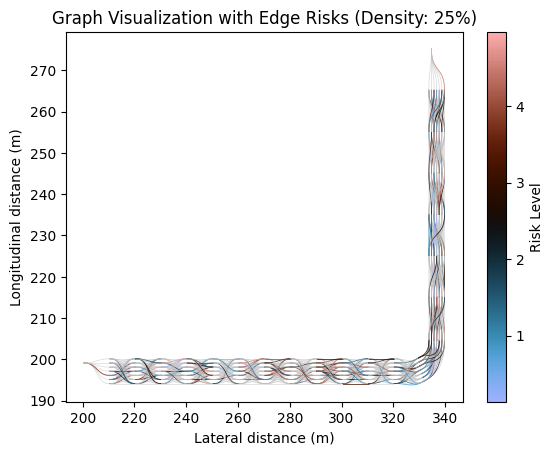

<Axes: title={'center': 'Graph Visualization with Edge Risks (Density: 25%)'}, xlabel='Lateral distance (m)', ylabel='Longitudinal distance (m)'>

In [4]:
from motion_planning.visualizations.graph_visualization import visualize_graph_with_risks
from motion_planning.risk_assessment.generate_risks_randomly import*
risk_level = RiskLevel.LOW
risk_matrix = generate_random_risks(graphs_dict["Town01_T-Intersection"],risk_level, 5.0)
visualize_graph_with_risks(risk_matrix, graphs_dict["Town01_T-Intersection"], scenario_name="Town01_T-Intersection", risk_level=risk_level)

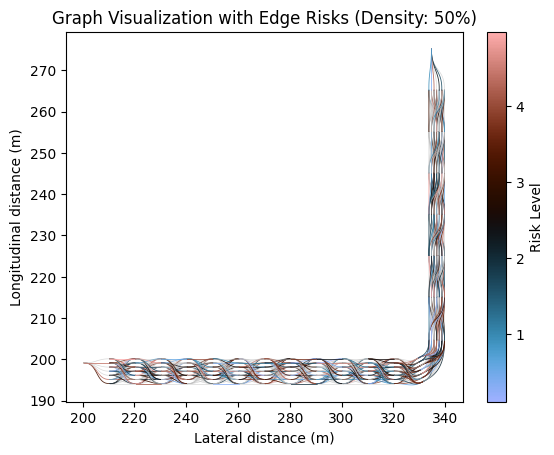

<Axes: title={'center': 'Graph Visualization with Edge Risks (Density: 50%)'}, xlabel='Lateral distance (m)', ylabel='Longitudinal distance (m)'>

In [5]:
from motion_planning.visualizations.graph_visualization import visualize_graph_with_risks
from motion_planning.risk_assessment.generate_risks_randomly import*
risk_level = RiskLevel.MEDIUM
risk_matrix = generate_random_risks(graphs_dict["Town01_T-Intersection"],risk_level, 5.0)
visualize_graph_with_risks(risk_matrix, graphs_dict["Town01_T-Intersection"], scenario_name="Town01_T-Intersection", risk_level=risk_level)

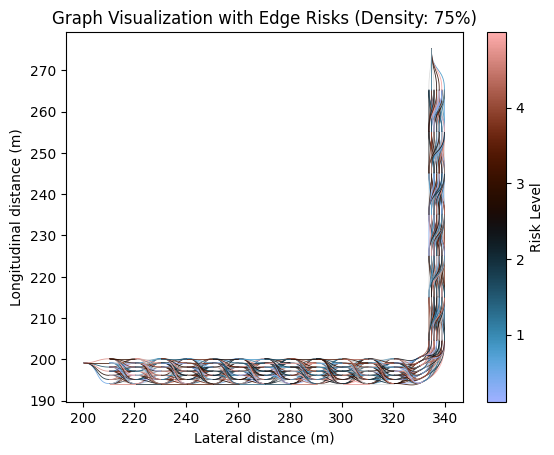

<Axes: title={'center': 'Graph Visualization with Edge Risks (Density: 75%)'}, xlabel='Lateral distance (m)', ylabel='Longitudinal distance (m)'>

In [6]:
from motion_planning.visualizations.graph_visualization import visualize_graph_with_risks
from motion_planning.risk_assessment.generate_risks_randomly import*
risk_level = RiskLevel.HIGH
risk_matrix = generate_random_risks(graphs_dict["Town01_T-Intersection"],risk_level, 5.0)
visualize_graph_with_risks(risk_matrix, graphs_dict["Town01_T-Intersection"], scenario_name="Town01_T-Intersection", risk_level=risk_level)

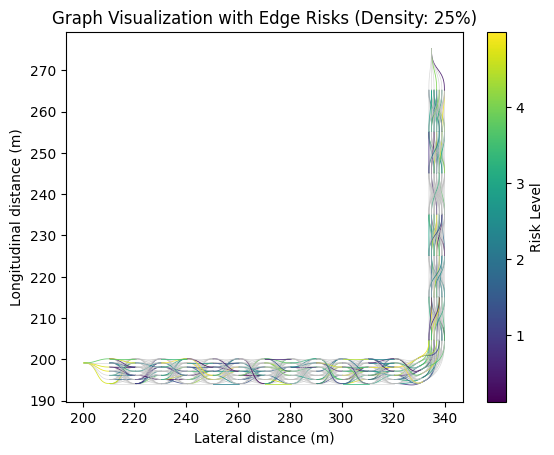

<Axes: title={'center': 'Graph With Edge Risks (speed=5)'}, xlabel='Lateral distance (m)', ylabel='Longitudinal distance (m)'>

In [7]:
from motion_planning.visualizations.graph_visualization import visualize_graph_with_risks
from motion_planning.visualizations.graph_visualization import visualize_graph_with_risks_with_speeds
from motion_planning.risk_assessment.generate_risks_randomly import*
risk_level = RiskLevel.LOW
risk_matrix = generate_random_risks(graphs_dict["Town01_T-Intersection"],risk_level, 5.0, with_speed=True)
visualize_graph_with_risks_with_speeds(risk_matrix, graphs_dict["Town01_T-Intersection"], scenario_name="Town01_T-Intersection", risk_level=risk_level)

1- CSP Basic (distance cost only)

2- CSP Basic (travel time cost only)

3- CSP Basic (travel time cost + lateral cost)

4- CSP Basic (travel time cost only)

In [ ]:
# CSP Basic solved with an edge-level risk matrix
from motion_planning.constrained_shortest_path.csp_basic import CSP_BASIC
from motion_planning.risk_assessment.generate_risks_randomly import RiskLevel, generate_random_risks

graph = graphs_dict["Town01_T-Intersection"]
start_node = next(node for node, data in graph.nodes(data=True) if data.get("layer") == 0)
goal_layer = max(data.get("layer") for _, data in graph.nodes(data=True))
goal_node = next(node for node, data in graph.nodes(data=True) if data.get("layer") == goal_layer)

risk_level = RiskLevel.MEDIUM
risk_matrix = generate_random_risks(graph, risk_level, 5.0)
risk_budget = 5.0

csp_basic_risk = CSP_BASIC(
    graph,
    start_node,
    goal_node,
    edge_cost_key="edge_cost",
    risk_max=risk_budget,
    risk_matrix=risk_matrix,
    output=False,
)

solution_edges = csp_basic_risk.solve()
print("Risk budget:", risk_budget)
print("Selected edges:", solution_edges)
print("Selected nodes:", csp_basic_risk.solution_path_nodes())

In [ ]:
# CSP Basic solved with speed-aware edge risks (single speed layer)
from motion_planning.constrained_shortest_path.csp_basic import CSP_BASIC
from motion_planning.risk_assessment.generate_risks_randomly import RiskLevel, generate_random_risks
from motion_planning.graph_construction.main_graph_construction import SPEED_SET

graph = graphs_dict["Town01_T-Intersection"]
start_node = next(node for node, data in graph.nodes(data=True) if data.get("layer") == 0)
goal_layer = max(data.get("layer") for _, data in graph.nodes(data=True))
goal_node = next(node for node, data in graph.nodes(data=True) if data.get("layer") == goal_layer)

risk_level = RiskLevel.MEDIUM
risk_matrix_with_speed = generate_random_risks(graph, risk_level, 5.0, with_speed=True)
speed_to_use = SPEED_SET[0]
edge_risks_for_speed = {
    (u, v): value
    for (u, v, speed), value in risk_matrix_with_speed.items()
    if speed == speed_to_use
}

risk_budget = 5.0
csp_basic_speed_risk = CSP_BASIC(
    graph,
    start_node,
    goal_node,
    edge_cost_key="edge_cost",
    risk_max=risk_budget,
    risk_matrix=edge_risks_for_speed,
    output=False,
)

solution_edges = csp_basic_speed_risk.solve()
print("Risk budget:", risk_budget, "(speed =", speed_to_use, "km/h)")
print("Selected edges:", solution_edges)
print("Selected nodes:", csp_basic_speed_risk.solution_path_nodes())

In [21]:
# CSP Full: edge and speed selection with risk budget
from motion_planning.constrained_shortest_path.csp_full import CSP_FULL
from motion_planning.risk_assessment.generate_risks_randomly import RiskLevel, generate_random_risks
from motion_planning.graph_construction.main_graph_construction import SPEED_SET
from motion_planning.constrained_shortest_path.gurobi_license import options
from motion_planning.constrained_shortest_path.costs_definitions import EDGE_COST
graph = graphs_dict["Town01_T-Intersection"]
start_node = next(node for node, data in graph.nodes(data=True) if data.get("layer") == 0)
goal_layer = max(data.get("layer") for _, data in graph.nodes(data=True))
goal_node = next(node for node, data in graph.nodes(data=True) if data.get("layer") == goal_layer)

risk_level = RiskLevel.HIGH
risk_matrix_with_speed = generate_random_risks(graph, risk_level, 5.0, with_speed=True)
risk_budget = 5.0

csp_full = CSP_FULL(
    graph,
    start_node,
    goal_node,
    edge_cost_list_key=EDGE_COST.EDGE_TIME_LATERAL_COST_LIST,
    speed_options=SPEED_SET,
    gurobi_env_params=options,
    risk_max=risk_budget,
    risk_matrix=risk_matrix_with_speed,
    output=False,
)

solution_edge_speeds = csp_full.solve()
print("Risk budget:", risk_budget)
# print("Selected edge-speed tuples:", solution_edge_speeds)
for u, v, speed in solution_edge_speeds:
    print(f"Selected edge ({u.id}, {v.id}) with speed {speed} km/h")
print("Selected nodes:", csp_full.solution_path_nodes())

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2649771
Academic license 2649771 - for non-commercial use only - registered to ab___@gmail.com
Risk budget: 5.0
Selected edge (v_0_0, v_1_1) with speed 20 km/h
Selected edge (v_1_1, v_2_1) with speed 20 km/h
Selected edge (v_2_1, v_3_1) with speed 30 km/h
Selected edge (v_3_1, v_4_2) with speed 30 km/h
Selected edge (v_4_2, v_5_3) with speed 25 km/h
Selected edge (v_5_3, v_6_3) with speed 20 km/h
Selected edge (v_6_3, v_7_2) with speed 30 km/h
Selected edge (v_7_2, v_8_2) with speed 30 km/h
Selected edge (v_8_2, v_9_2) with speed 30 km/h
Selected edge (v_9_2, v_10_3) with speed 30 km/h
Selected edge (v_10_3, v_11_3) with speed 5 km/h
Selected edge (v_11_3, v_12_3) with speed 25 km/h
Selected edge (v_12_3, v_13_3) with speed 30 km/h
Selected edge (v_13_3, v_14_3) with speed 20 km/h
Selected edge (v_14_3, v_15_2) with speed 30 km/h
Selected edge (v_15_2, v_16_2) with speed 30 km/h
Selected edge (v_16_2, v_

In [16]:
for u, v, speed in solution_edge_speeds:
    print(f"Selected edge ({u.id}, {v.id}) with speed {speed} km/h")

Selected edge (v_0_0, v_1_6) with speed 30 km/h
Selected edge (v_1_6, v_2_6) with speed 30 km/h
Selected edge (v_2_6, v_3_6) with speed 30 km/h
Selected edge (v_3_6, v_4_6) with speed 30 km/h
Selected edge (v_4_6, v_5_7) with speed 30 km/h
Selected edge (v_5_7, v_6_7) with speed 30 km/h
Selected edge (v_6_7, v_7_6) with speed 30 km/h
Selected edge (v_7_6, v_8_6) with speed 30 km/h
Selected edge (v_8_6, v_9_5) with speed 30 km/h
Selected edge (v_9_5, v_10_5) with speed 30 km/h
Selected edge (v_10_5, v_11_6) with speed 30 km/h
Selected edge (v_11_6, v_12_7) with speed 30 km/h
Selected edge (v_12_7, v_13_7) with speed 30 km/h
Selected edge (v_13_7, v_14_7) with speed 30 km/h
Selected edge (v_14_7, v_15_6) with speed 30 km/h
Selected edge (v_15_6, v_16_5) with speed 30 km/h
Selected edge (v_16_5, v_17_5) with speed 30 km/h
Selected edge (v_17_5, v_18_5) with speed 30 km/h
Selected edge (v_18_5, v_19_5) with speed 30 km/h
Selected edge (v_19_5, v_20_5) with speed 30 km/h
Selected edge (v_20